In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from functools import partial
import random
#import cv2
from PIL import Image
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import copy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

#### Carregar as fotos
Carrega a foto, reescalona (resize) e retorna o seu formato em RGB.

In [2]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

#### Carregar os pixels RGB da imagem

retorna um DataFrame com as coordenadas RGB da imagem.

In [3]:
def pick_pixels(photo):
    n , m = photo.size
    ibagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            ibagem.append(list(pixels[i,j]))
    return pd.DataFrame(ibagem)

#### Colorir a imagem
Colore a imagem com as respectivas cores dos centroides. 

In [4]:
def coloring(photo, labels, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            numb = [int(number) for number in centers[labels[i*m + j]] ] 
            pixels[i,j]= tuple(numb)
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

### Carregar dados

In [24]:
def import_data():
    data = loadmat('fcm_dataset.mat')
    data = pd.DataFrame(data['x'])
    lendata = len(data)
    print('Numero de obervacoes: ', lendata)
    nfeatures = data.shape[1]
    print('Numero de atributos (features): ', nfeatures)

    return data.values#.transpose()

def reduc_samples(X,n_samples=10):
    return X[:n_samples, :]

def plot_samples(x, u, centroids):
    y_kmeans = np.argmax(u, axis=1)
    plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.show()

def plot_samples3D(x, u, centroids):
    y_ = np.argmax(u, axis=1)
    target_names = ['Red','Green','Blue']
    colors = ['navy', 'turquoise', 'darkorange']
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2], 
                c=y_, cmap='viridis',
                edgecolor='k', s=40, alpha = 0.2)


    ax.set_title("RGB information Fuzzy Kmeans")
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    ax.dist = 10

    for cent in centroids:
        ax.scatter(cent[0],cent[1], cent[2], 
               s = 300, c = 'r', marker='*',alpha = 1.,label = 'Centroid')

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()

#### Algoritmo Fuzzy K means

In [ ]:
def generate_u(k: int, n: int):
    return np.random.dirichlet(np.ones(k), size=n)


# returns array of K centroids
def calc_centroids(U, X, m):
    centroids = []
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    for i in range(n_centroids):
        u_i = U[:,i] 
        ui_m = u_i ** m

        features_cent = []
        n_feat_cent = int(X.shape[1])
        for feat in range(n_feat_cent):
            x_feat = X[:,feat]
            feat_cent = np.sum((ui_m*x_feat))/np.sum(ui_m) 
            features_cent.append(feat_cent)
        centroids.append(features_cent)

    centroids = np.array(centroids)
    return centroids


def calc_cost(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    cost = 0

    for i in range(n_centroids):
        for j in range(n_samples):
            dist = distance.euclidean(centroids[i], X[j,:])
            cost += (U[j][i] ** m) * (dist ** 2)

    return cost


def update_u(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    U_new = copy.copy(U)

    for j in range(n_samples):
        dist_kj = 0
        for k in range(n_centroids):
            dist_kj += distance.euclidean(centroids[k], X[j,:])
        for i in range(n_centroids):
            dist_ij = distance.euclidean(centroids[i], X[j,:])
            U_new[j][i] = 1 / (dist_ij / dist_kj) ** (2/(m - 1))
        #normaliza valores entre 0 e 1 para cada amostra
        sum_ = np.sum(U_new[j])
        U_new[j] = U_new[j]/sum_
    
    return U_new

# x: dataset composto de pontos no plano cartesiano (número de dimensões arbitrário)
# n_centroides: número desejado de clusters
# m: exponente de peso
def fuzzy_k_means(x, n_centroides, m, threshold = 0.001, max_inter = 10, plot='no' , log = False):
    if m <= 1:
        raise Exception(" 'm' should be greater than 1")

    u = generate_u(n_centroides, x.shape[0])
    cost = 1
    centroids = []
    iterations = 0
    while cost > threshold and iterations < max_inter:
        print('Interação {}'.format(iterations+1))
        centroids = calc_centroids(u, x, m)
        cost = calc_cost(u, x, centroids, m)
        u = update_u(u, x, centroids, m)
        iterations += 1
        print('Erro : {}'.format(cost))
        if log:
            print('Matrix centroids: {}'.format(centroids))
            print('Matrix U: {}'.format(u))
        if plot == '2D':
            plot_samples(x, u, centroids)
        elif plot == '3D':
            plot_samples3D(x, u, centroids)

    
    return {'centroids': centroids, 'u_matrix': u, 'n_iterations': iterations}

### Executando algoritmo para dados 2D

Numero de obervacoes:  800
Numero de atributos (features):  2
Interação 1
Erro : 201.73711798778163


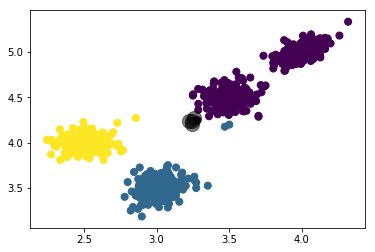

Interação 2
Erro : 127.1750597109582


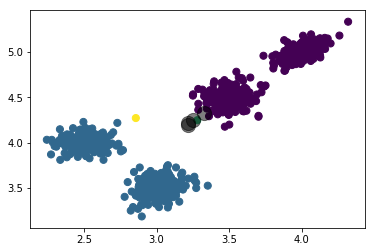

Interação 3
Erro : 120.5567546337331


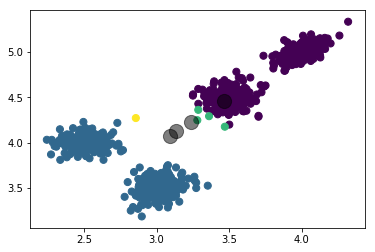

Interação 4
Erro : 93.72329901831345


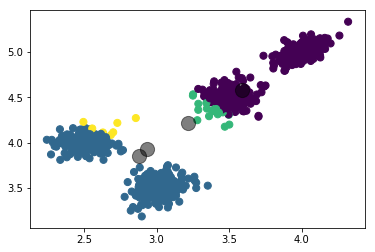

Interação 5
Erro : 68.2707938689677


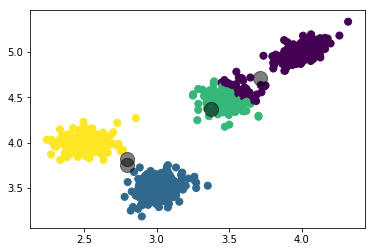

Interação 6
Erro : 43.803198860594435


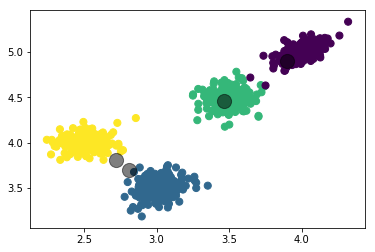

Interação 7
Erro : 26.25852123093067


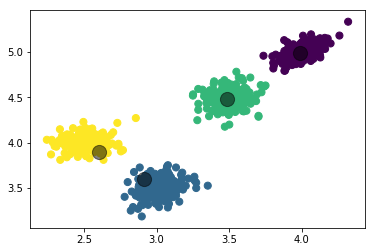

Interação 8
Erro : 13.620912455594864


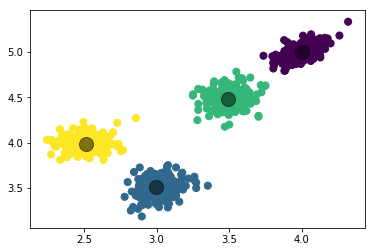

Interação 9
Erro : 12.443115020587047


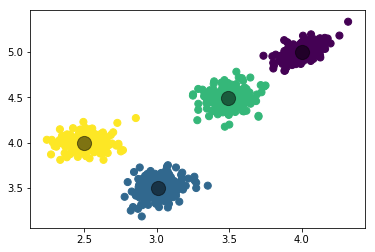

Interação 10
Erro : 12.433573263840175


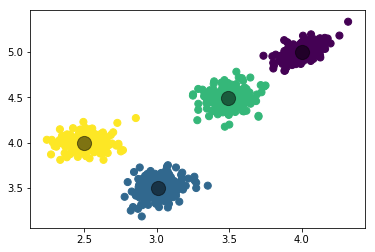

Interação 11
Erro : 12.43349534036201


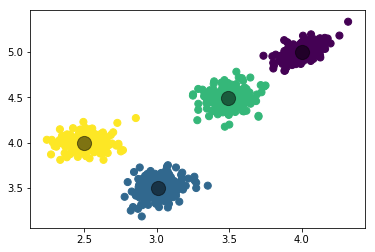

Interação 12
Erro : 12.433494539427938


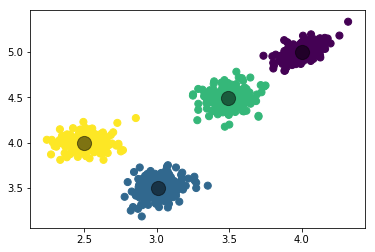

Interação 13
Erro : 12.433494528382532


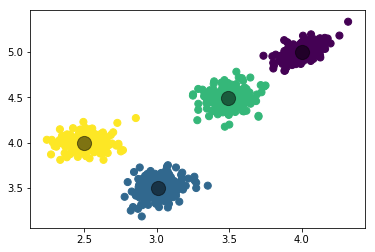

Interação 14
Erro : 12.433494528187547


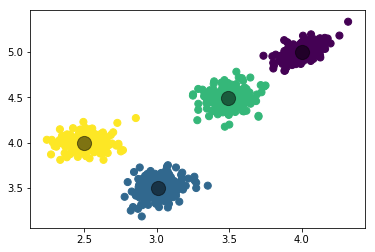

Interação 15
Erro : 12.433494528183518


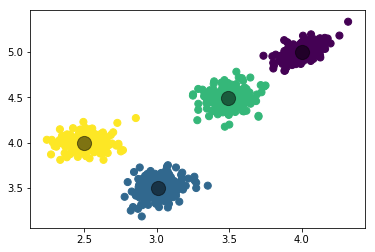

Interação 16
Erro : 12.433494528183454


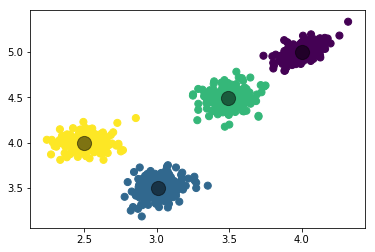

Interação 17
Erro : 12.433494528183465


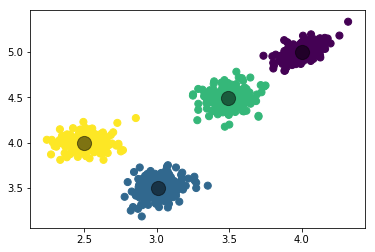

Interação 18
Erro : 12.433494528183418


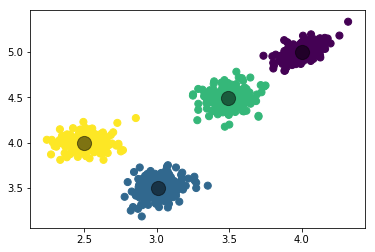

Interação 19
Erro : 12.433494528183461


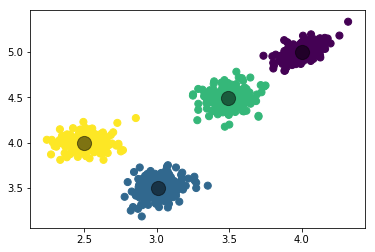

Interação 20
Erro : 12.433494528183441


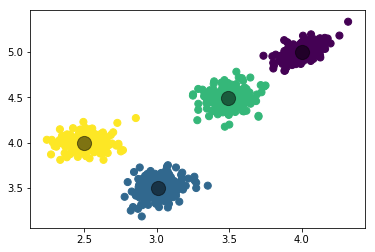

Resultado
Centroides: [[4.00143358 5.0040403 ]
 [3.01197725 3.49987834]
 [3.49398867 4.48756343]
 [2.50120339 3.99164153]]
Número de interações: 20
Matriz U: [[9.62213531e-01 5.28454925e-03 2.71433729e-02 5.35854647e-03]
 [8.51086063e-01 1.36986192e-02 1.20864855e-01 1.43504633e-02]
 [9.84052589e-01 1.91128122e-03 1.22039311e-02 1.83219844e-03]
 ...
 [4.52884166e-04 2.89311393e-03 1.17172134e-03 9.95482281e-01]
 [9.03773618e-04 5.71120593e-03 2.31183161e-03 9.91073189e-01]
 [4.00871035e-03 2.08238564e-02 9.96378358e-03 9.65203650e-01]]


In [12]:
X = import_data()
result = fuzzy_k_means(X, 4, 2, 0.1, 20, plot = '2D', log = False)
print('Resultado')
print('Centroides: {}'.format(result['centroids']))
print('Número de interações: {}'.format(result['n_iterations']))
print('Matriz U: {}'.format(result['u_matrix']))

### Exemplo de Fluxo de Execução
Isto deve ser feito para cada imagem

(273280, 3)


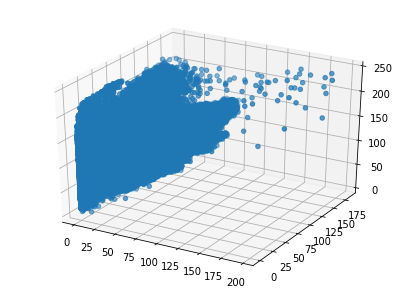

In [13]:
filename = './../ImagensTeste/photo001.jpg'
# código exemplo

photo = photo_open(filename)
pixels = pick_pixels(photo).values
print(pixels.shape)
plt.figure('Pixels RGB da imagem', figsize=(7,5))
ax = plt.axes(projection = '3d')
ax.scatter(pixels[:,0],pixels[:,1],pixels[:,2])
plt.show()

Interação 1
(273280, 4)
(273280, 3)
Erro : 697952625.0848109
Matrix centroids: [[120.1013086   54.88063969  22.87648928]
 [120.04723449  55.34632541  23.08767819]
 [119.94635711  54.93543884  22.95699635]
 [120.0678825   54.93371672  22.95741209]]
Matrix U: [[0.24899808 0.2512158  0.2502111  0.24957502]
 [0.24902622 0.25113907 0.25024742 0.24958729]
 [0.24902622 0.25113907 0.25024742 0.24958729]
 ...
 [0.24963306 0.24995304 0.25058653 0.24982737]
 [0.2496096  0.24998754 0.25058596 0.24981691]
 [0.24969844 0.24985998 0.25058502 0.24985656]]
(273280, 3)


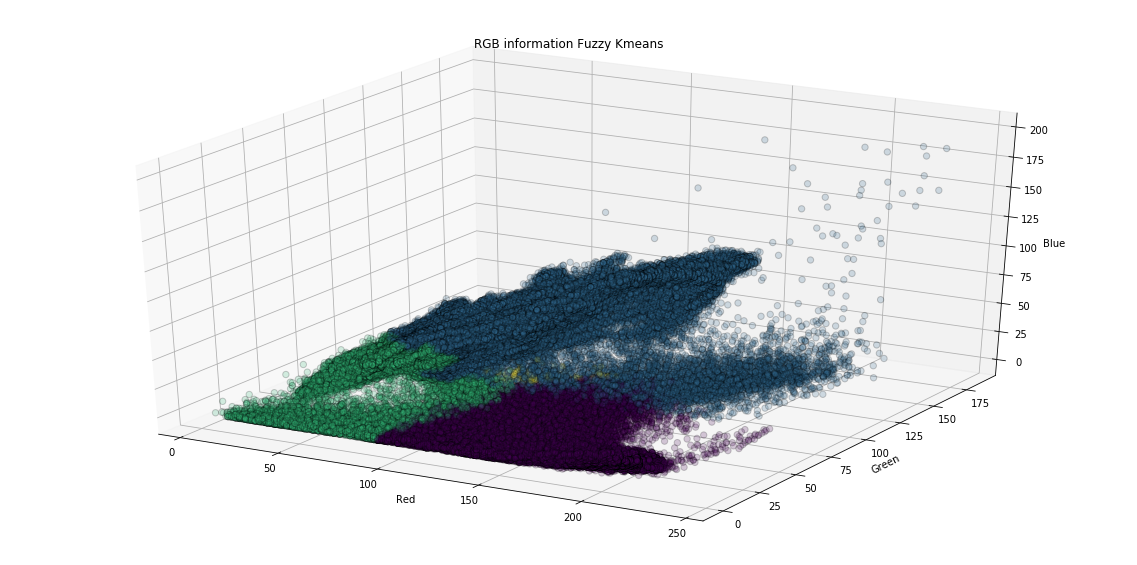

Interação 2
(273280, 4)
(273280, 3)


In [ ]:
result = fuzzy_k_means(pixels, 4, 2, 0.1, 10, plot = '3D', log = True)


# labels, centers = KMeans(k = 4)     ....  chama o KMeans ou Fuzzy-CMeans
#photo = coloring(photo, labels, centers)